In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [21]:
import math
import random

import pickle
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter


In [74]:
saved_model_dir = "saved_model/general_full_data_training/" # for saving weights
if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)

saving_dir = "explain/general_full_data_training/"
if not os.path.exists(saving_dir):
    os.makedirs(saving_dir)

np.random.seed(7) # fix random seed for reproducibility
torch.manual_seed(7)

NUM_LAYERS = 1
HIDDEN_SIZE = 64
TRAIN_EPOCHS = 300

TRAIN_BATCHES = 2048
TEST_SIZE = 0.1
VALID_SIZE = 0.1

SEQ_LENGTH = 4

with open('huge_pd_shuffled_with_rewards_original_seq4_SHUFFLED.pkl', 'rb') as f: # load sequences dataset
    huge_pd = pickle.load(f)

In [75]:
#huge_pd.isna().sum()
huge_pd.head(10)

,index,user,choice,reward,time,payoff_structure,reward_1,reward_2,reward_3,reward_4,orig_choice_num,prev_choice,prev_reward
412,104,734,4,38,1210.0,4,43,50,58,38,108,4,57
413,105,734,1,33,629.0,4,33,38,54,39,109,4,38
414,106,734,1,32,465.0,4,32,43,63,39,110,1,33
415,107,734,1,27,532.0,4,27,42,52,35,111,1,32
408,103,73,3,83,1277.0,2,31,54,83,50,104,2,62
409,104,73,2,58,1040.0,2,35,58,85,38,105,3,83
410,105,73,3,71,1197.0,2,35,55,71,41,106,2,58
411,106,73,1,34,1126.0,2,34,52,74,42,107,3,71
168,43,217,2,55,562.0,2,52,55,60,17,44,1,53
169,44,217,2,61,1079.0,2,56,61,59,16,45,2,55


Each line of the dataframe is a choice made by one user :
- The payoff structure is the scenario in which the user is playing.
- Rewards that each bandit could give is indicated.
- Orig_choice_num indicates the order of choices made by each player.
- Prev choice and reward indicate the reward the action and reward of the player at previous choice.

Choices are grouped by four with a same user, pseudo-consecutive structure

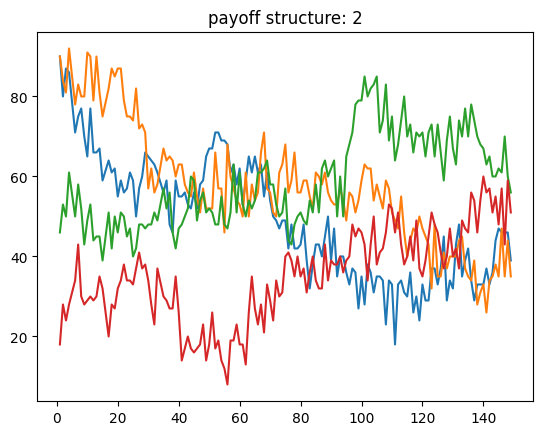

In [76]:
for r in ['1', '2', '3', '4']:
    plt.plot(huge_pd[(huge_pd.user == 20)].sort_values(by='orig_choice_num')['orig_choice_num'],
             huge_pd[(huge_pd.user == 20)].sort_values(by='orig_choice_num')['reward_'+r])
plt.title('payoff structure: ' + str(int(huge_pd[huge_pd.user == 20].payoff_structure.unique()[0])))
plt.show()

### X and y data preparation

In [77]:
# Copy dataframe
cur_data = huge_pd.copy()

# Index choices in [[0, 3]]
cur_data['choice'] = cur_data.choice.apply(lambda x: x - 1)
cur_data['prev_choice'] = cur_data.prev_choice.apply(lambda x: x - 1)

# Select prev_choice and prev_reward columns to prepare the observed choices data
X = cur_data.drop(columns=['index', 'choice', 'user', 'time', 'reward', 'payoff_structure', 'reward_1', 'reward_2', 'reward_3', 'reward_4'])

# Select current choice to prepare the choice to predict
y = cur_data.choice

# One hot encoding previous choices
num_of_classes = len(y.unique()) #4
X_prev = X.prev_choice.to_numpy()
X_prev = F.one_hot(torch.tensor(X_prev, dtype = torch.int64), num_classes=num_of_classes)

# One hot encoding current choices
num_of_classes = len(y.unique())
y = y.to_numpy()
y = F.one_hot(torch.tensor(y, dtype=torch.int64), num_classes = num_of_classes)

# Create the array of previous choice and previous rewards to prepare X tensor
new_X = []
for prev_choice, prev_reward in zip(X_prev, X.prev_reward):
    new_i = np.append(prev_choice, prev_reward) # Concatenates the prev_choice (one hot vector of size 4) and the prev reward
    new_X.append(new_i)

new_X = np.array(new_X)
print(np.shape(new_X))
print(y.shape)

seq_data = cur_data.reset_index(drop=True).copy()

(543824, 5)
torch.Size([543824, 4])


### Let's do a check of how many sequences of 4 choices are discontinuous

In [78]:
def is_continuous_sequence(choice_numbers):
# gets a list and return True if the sequence is continuous without gaps, otherwise return False
    for c in range(1, 4):
        if choice_numbers[c] - choice_numbers[c-1] > 1:
            return False
    return True

print("For example, sequence with choice indexes [45,46,47,48] is", ["discontinuous", "continuous"][is_continuous_sequence([45,46,47,48])])
print("while sequence with choice indexes [45,49,52,53] is", ["discontinuous", "continuous"][is_continuous_sequence([45,49,52,53])])

start = 0
end = 4

continuous_counter = 0
not_continuous_counter = 0
more_than_one_gap_seq = []

for i in range(start, seq_data.shape[0],4):
    if i == 0 :
        start = 0
        end = start + 4
    start = i
    end = start + 4
    cur_orig_choices = list(seq_data[start:end]['orig_choice_num'])
    assert(len(seq_data[start:end]['user'].unique())==1)

    if is_continuous_sequence(cur_orig_choices):
        continuous_counter += 1
    else:
        not_continuous_counter += 1
        more_than_one_gap_seq.append(cur_orig_choices)

print('number of continuous sequences :', continuous_counter)
print('number of discontinuous sequences :', not_continuous_counter)

assert(continuous_counter+not_continuous_counter==seq_data.shape[0]//4)

def how_continuous_sequence(choice_numbers):
    '''
    gets a list and returns : the highest gap in the sequence, total gap
    '''
    highest_gap = 0
    gap_sum = 0
    for c in range(1, 4):
        gap = choice_numbers[c] - choice_numbers[c-1]

        if gap>highest_gap:
            highest_gap = gap
        gap_sum += gap

    return highest_gap, gap_sum

# check the more_than_one_gap_seq - how many gaps there is
highest_gaps = []
gaps_sums = []
for i in range(len(more_than_one_gap_seq)):
    highest_gap, gap_sum = how_continuous_sequence(more_than_one_gap_seq[i])
    highest_gaps.append(highest_gap)
    gaps_sums.append(gap_sum)

highest_gaps_counter = Counter(highest_gaps)
gaps_sums_counter = Counter(gaps_sums)

For example, sequence with choice indexes [45,46,47,48] is continuous
while sequence with choice indexes [45,49,52,53] is discontinuous
number of continuous sequences : 128523
number of discontinuous sequences : 7433


In [79]:
highest_gaps_counter

Counter({2: 6555,
         3: 559,
         4: 153,
         6: 31,
         21: 2,
         39: 3,
         7: 34,
         34: 1,
         8: 7,
         5: 44,
         13: 3,
         15: 3,
         27: 3,
         11: 9,
         10: 8,
         9: 6,
         14: 5,
         76: 3,
         17: 1,
         22: 3})

In [80]:
gaps_sums_counter

Counter({4: 6039,
         5: 773,
         6: 336,
         7: 98,
         8: 56,
         52: 2,
         54: 1,
         10: 17,
         36: 1,
         12: 17,
         9: 35,
         11: 11,
         15: 6,
         17: 3,
         13: 16,
         19: 1,
         79: 1,
         42: 1,
         23: 2,
         60: 1,
         34: 1,
         26: 2,
         51: 1,
         83: 1,
         82: 1,
         14: 2,
         22: 2,
         41: 2,
         32: 1,
         25: 2,
         16: 1})

As expected, the large majority of the discontinuous sequences have a small gap (<10 choices). We won't handle them (the lstm will treat them like normal sequences), as the original authors did not considered further handling of those gapped sequences.

In [81]:
def my_train_test_split(X, y, sequence_length, valid_size=VALID_SIZE, test_size=TEST_SIZE, debug_print=False):
    """
    Gathers train, test and valid samples so that each dataset contains sequences of 4
    Modified from the authors original version to generate the valid set
    """
    #initial split
    train_samples = int(np.ceil(X.shape[0] * (1 - test_size - valid_size)))
    test_samples = int(np.floor(X.shape[0] * test_size))
    valid_samples = X.shape[0] - train_samples - test_samples

    # adjust split size to get datasets of length that can be divided by 4
    divide_train = train_samples % sequence_length == 0
    while not (divide_train):
        train_samples += 1
        divide_train = train_samples % sequence_length == 0
    divide_test = test_samples % sequence_length == 0
    while not (divide_test):
        test_samples -= 1
        valid_samples += 1
        divide_test = test_samples % sequence_length == 0
    divide_valid = valid_samples % sequence_length == 0
    while not (divide_valid):
        valid_samples -= 1
        divide_valid = valid_samples % sequence_length == 0

    print("num train samples = ", train_samples)
    print("num test samples = ", test_samples)
    print("num valid samples = ", valid_samples)

    X_train = X[0:train_samples]
    X_test = X[train_samples:train_samples + test_samples].copy()
    X_valid = X[train_samples + test_samples : train_samples + test_samples + valid_samples].copy()

    y_train = y[0:train_samples]
    y_test = y[train_samples:train_samples+len(X_test)]
    y_valid = y[train_samples+len(X_test): train_samples+len(X_test)+len(X_valid)]

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [82]:
X_train, X_test, X_valid, y_train, y_test, y_valid = my_train_test_split(new_X, y, sequence_length = SEQ_LENGTH, test_size = 0.1, valid_size = 0.1)

assert np.shape(X_train)[0] == y_train.shape[0]
assert np.shape(X_test)[0] == y_test.shape[0]
assert np.shape(X_valid)[0] == y_valid.shape[0]


possible_samples = int(new_X.shape[0] / SEQ_LENGTH)
possible_samples_train = int(X_train.shape[0] / SEQ_LENGTH)
possible_samples_test = int(X_test.shape[0] / SEQ_LENGTH)
possible_samples_valid = int(X_valid.shape[0] / SEQ_LENGTH)
possible_labels_train = int(y_train.shape[0] / SEQ_LENGTH)
possible_labels_test = int(y_test.shape[0] / SEQ_LENGTH)
possible_labels_valid = int(y_valid.shape[0] / SEQ_LENGTH)

# reshape to be [N (samples), L (seq len), H (features dim)]
X_train = np.reshape(X_train, (possible_samples_train, SEQ_LENGTH, X_train.shape[1]))
X_test = np.reshape(X_test, (possible_samples_test, SEQ_LENGTH, X_test.shape[1]))
X_valid = np.reshape(X_valid, (possible_samples_valid, SEQ_LENGTH, X_valid.shape[1]))

y_cat_train = np.reshape(y_train, (possible_samples_train, SEQ_LENGTH, y_train.shape[1]))
y_cat_test = np.reshape(y_test, (possible_labels_test, SEQ_LENGTH, y_test.shape[1]))
y_cat_valid = np.reshape(y_valid, (possible_labels_valid, SEQ_LENGTH, y_valid.shape[1]))

num_of_samples = y_cat_test.shape[0]
X_train = torch.tensor(X_train.copy(), dtype = torch.float32)
X_test = torch.tensor(X_test.copy(), dtype = torch.float32)
X_valid = torch.tensor(X_valid.copy(), dtype = torch.float32)

dataset_dict = {'train' : (X_train, y_cat_train), 'test' : (X_test, y_cat_test), 'valid' : (X_valid, y_cat_valid)}

# Save data
filename_dataset_dict = 'train_test_valid_data_dict.pkl'
with open(filename_dataset_dict, 'wb') as f:
    pickle.dump(dataset_dict, f)


num train samples =  435060
num test samples =  54380
num valid samples =  54384


In [83]:
# for gpu acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train=X_train.to(device)
y_cat_train=y_cat_train.to(device)
X_test=X_test.to(device)
y_cat_test=y_cat_test.to(device)


In [84]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_cat_train[:, -1, :])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCHES, shuffle=True)

In [85]:
class Model(nn.Module):
    """
    LSTM model for choice prediction
    """
    def __init__(self, input_size = 5, output_size = 4, batch_size = TRAIN_BATCHES, hidden_size=HIDDEN_SIZE):
        super(Model, self).__init__()

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)  # input shape [N, L, H]
        self.linear_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x) # output shape [N, L, H]
        probs = self.linear_layer(output[:, -1, :]) # output shape [N, 4]
        return probs

In [86]:
def train_step(model, l, optim, x_batch, y_batch):

    probs = model(x_batch)     # output of the LSTM

    loss = l(probs, y_batch.float())   # cross entropy

    _, predictions = torch.max(probs, 1)   # compute accuracy
    _, true_label = torch.max(y_batch, 1)
    accuracy = torch.mean((predictions == true_label).float())

    optim.zero_grad()   # gradient descent
    loss.backward()
    optim.step()

    return loss, accuracy

def test_on_whole_data(model, l, x = X_test, y = y_cat_test[:, -1, :]):

    probs = model(x)   # output of the LSTM

    loss = l(probs, y.float())   # cross entropy

    _, predictions = torch.max(probs, 1)   # compute accuracy
    _, true_label = torch.max(y, 1)
    accuracy = torch.mean((predictions == true_label).float())

    del _, probs, predictions, true_label
    return loss, accuracy

In [87]:
def train(model_path, test = False):

    model = Model() # init model
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.9999))
    ce_loss = nn.CrossEntropyLoss()

    accs_over_epochs, loss_over_epochs, loss_test_over_epochs, accs_test_over_epochs = [],[],[],[]

    for epoch in range(TRAIN_EPOCHS):
        accs_over_batches, loss_over_batches = [],[]

        for x_batch, y_batch in train_dataloader :
                loss, accuracy = train_step(model, ce_loss, optimizer, x_batch, y_batch) # gradient descent on the next batch
                accs_over_batches.append(accuracy.item())
                loss_over_batches.append(loss.item())
                del loss
                del accuracy
        print(f"Finished epoch {epoch + 1}, acc {np.mean(accs_over_batches):.4f}, loss {np.mean(loss_over_batches):.4f}")

        accs_over_epochs.append(np.mean(accs_over_batches)) # store acc and loss over epochs
        loss_over_epochs.append(np.mean(loss_over_batches))

        if test :
            loss_test, accuracy_test = test_on_whole_data(model, ce_loss)
            loss_test_over_epochs.append(loss_test.cpu().detach().numpy())
            accs_test_over_epochs.append(accuracy_test.cpu().detach().numpy())

    print("---------------------------------------------------------------")
    print(f"Final Accuracy: {accs_over_epochs[-1]:.4f}")
    print(f"Average Accuracy: {np.mean(accs_over_epochs):.4f}")
    print("Final Loss:")
    print(f"{loss_over_epochs[-1]:.4f}")
    print(f"Average Loss: {np.mean(loss_over_epochs):.4f}")

    torch.save(model.state_dict(), model_path)          # Save the model

    return accs_over_epochs, loss_over_epochs, accs_test_over_epochs, loss_test_over_epochs

In [88]:
X_train[12, :, :], y_cat_train[12, :, :]  # la dernière ligne d'un élement de y_cat correspond au 5ème choix de la séquence

(tensor([[ 0.,  1.,  0.,  0., 81.],
         [ 0.,  1.,  0.,  0., 74.],
         [ 0.,  0.,  1.,  0., 17.],
         [ 1.,  0.,  0.,  0., 34.]], device='cuda:0'),
 tensor([[0, 1, 0, 0],
         [0, 0, 1, 0],
         [1, 0, 0, 0],
         [0, 1, 0, 0]], device='cuda:0'))

In [89]:
### TRAINING LOOP ####

model_path = saved_model_dir + "torch_model"

accuracies_per_epoch, losses_per_epoch, accs_test, loss_test = train(model_path = model_path, test = True)
train_results = accuracies_per_epoch, losses_per_epoch
with open(os.path.join(saved_model_dir, 'model_with_torch_batch{}_results.pkl'.format(TRAIN_BATCHES)), 'wb') as handle:
    pickle.dump(train_results, handle)

Finished epoch 1, acc 0.3723, loss 1.2884
Finished epoch 2, acc 0.5341, loss 1.1374
Finished epoch 3, acc 0.6326, loss 0.9401
Finished epoch 4, acc 0.6746, loss 0.8866
Finished epoch 5, acc 0.6795, loss 0.8633
Finished epoch 6, acc 0.6846, loss 0.8501
Finished epoch 7, acc 0.6875, loss 0.8406
Finished epoch 8, acc 0.6900, loss 0.8310
Finished epoch 9, acc 0.6924, loss 0.8244
Finished epoch 10, acc 0.6962, loss 0.8155
Finished epoch 11, acc 0.6974, loss 0.8098
Finished epoch 12, acc 0.7000, loss 0.8043
Finished epoch 13, acc 0.7030, loss 0.7983
Finished epoch 14, acc 0.7047, loss 0.7931
Finished epoch 15, acc 0.7067, loss 0.7882
Finished epoch 16, acc 0.7074, loss 0.7844
Finished epoch 17, acc 0.7097, loss 0.7807
Finished epoch 18, acc 0.7117, loss 0.7766
Finished epoch 19, acc 0.7135, loss 0.7740
Finished epoch 20, acc 0.7153, loss 0.7700
Finished epoch 21, acc 0.7157, loss 0.7703
Finished epoch 22, acc 0.7165, loss 0.7673
Finished epoch 23, acc 0.7189, loss 0.7645
Finished epoch 24, a

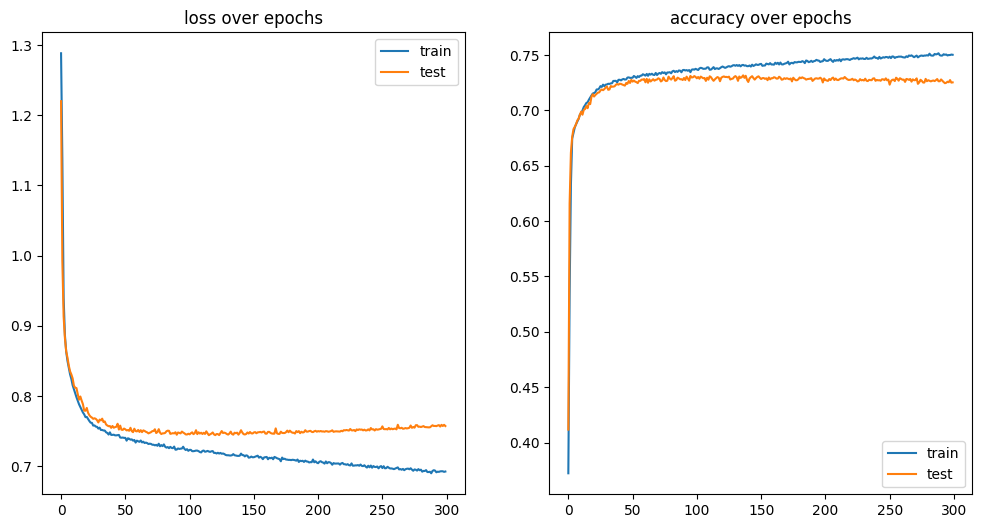

In [90]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot([k for k in range(TRAIN_EPOCHS)], losses_per_epoch, label = 'train')
ax[0].plot([k for k in range(TRAIN_EPOCHS)], loss_test, label = 'test')

ax[0].set_title('loss over epochs')
ax[0].legend()
ax[1].plot([k for k in range(TRAIN_EPOCHS)], accuracies_per_epoch, label = 'train')
ax[1].plot([k for k in range(TRAIN_EPOCHS)], accs_test, label = 'test')

ax[1].set_title('accuracy over epochs')
ax[1].legend()
plt.show()

## simulating with custom inputs

In [91]:
def get_last_seq(person_df, choice_number, seq_len, debug_prints=False):
    """
    Gets a person's data and a choice number and returns a sequence of previous 4 (or seq_length) choices made (maybe not 4 (seq_length) consecutives)
    """
    if choice_number < seq_len:
        if debug_prints: print("must be {} and more to get a sequence".format(seq_len))
        return -2
    ind = np.where(person_df["orig_choice_num"] == choice_number)
    if len(ind[0]) == 0:
        if debug_prints: print("choice number {} not found".format(choice_number))
        return -9
    elif len(ind[0]) > 1:
        if debug_prints: print("FOR SOME REASON THERE'S MORE THAN ONE CHOICE NUMBER LIKE {}".format(choice_number))
        return -1
    # got here so I found the choice number , now lets check if we have 4 previous choices
    seq = []
    for i in range(ind[0][0] - seq_len + 1, ind[0][0] + 1, 1):
        seq.append(i)
    return person_df.iloc[seq]

In [108]:
def create_data_sequence(seq_df, seq_len):
    """
    gets a SINGLE sequence in df form and returns it in a train/test ready form (numpy) X and y
    """
    cur_data = seq_df.copy()
    cur_data['choice'] = cur_data.choice.apply(lambda x: x - 1)
    cur_data['prev_choice'] = cur_data.prev_choice.apply(lambda x: x - 1)
    X = cur_data.drop(
        columns=['choice', 'user', 'time', 'reward', 'payoff_structure', 'reward_1', 'reward_2', 'reward_3', 'reward_4',
                 'orig_choice_num'])
    X_prev = F.one_hot(X.prev_choice, num_classes=4, dtype='int64')
    y = cur_data.choice
    num_of_classes = len(y.unique())
    y = F.one_hot(y, num_classes=4, dtype='int64')

    new_X = []
    for prev_choice, prev_reward in zip(X_prev, X.prev_reward):
        new_i = np.append(prev_choice, prev_reward)
        new_X.append(new_i)
    new_X = np.array(new_X)

    # reshape X to be [samples, time steps, features]
    X_reshaped = np.reshape(new_X, (1, seq_len, new_X.shape[1]))
    y_reshaped = np.reshape(y, (1, seq_len, y.shape[1]))

    return X_reshaped, y_reshaped

In [141]:
def create_fake_sequence(seq, rewards, seq_len = SEQ_LENGTH):
    """
    seq - is the input : array with 4 ints in range 0-3
    rewards - are the corresponding rewards array at each time
    returns x, y in a sequence format
    """

    X_prev = F.one_hot(torch.tensor(seq), num_classes=4)

    new_X = []
    for prev_choice, prev_reward in zip(X_prev, rewards):
        new_i = np.append(prev_choice, prev_reward)
        new_X.append(new_i)
    new_X = np.array(new_X)

    # reshape X to be [samples, time steps, features]
    X_reshaped = np.reshape(new_X, (1, seq_len, new_X.shape[1]))

    return X_reshaped

In [181]:
def make_prediction(input_seq, input_rewards, print_to_screen=True, print_to_log=True):
    """
    input: a sequence and rewards , both as lists of ints
    returns: a prediction
    """
    fake_x = create_fake_sequence(seq=input_seq,rewards=input_rewards)
    model = Model()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    probs = model(torch.tensor(fake_x, dtype = torch.float32))
    class_pred = torch.max(probs, 1)[1].detach().numpy()
    if print_to_screen:
        print("predicted class: ",class_pred[0])
        print(probs)

    return (class_pred[0], probs.detach().numpy())

In [175]:
def run_fake_seq():
    """
    wrapper for running a new sequence
    if input is "exit" at any phase, exiting the outer loop
    """
    g = input("Enter a sequence of choices: ")
    if g == "exit":
        return 1
    input_seq = [int(x) for x in g.split()]
    r = input("Enter the corresponding rewards: ")
    if g == "exit":
        return 1
    input_rewards = [int(x) for x in r.split()]

    make_prediction(input_seq, input_rewards)

    return 0

In [176]:
def continuous_run():
    halt = 0
    while not halt:
        halt = run_fake_seq()

In [177]:
def split_prediction_argmax(cell):
    splitted_cell = cell.split()
    return int(splitted_cell[0]), float(splitted_cell[1].replace('[','').replace(']',''))

In [178]:
def produce_comparison_df(output_with_argmax, generated_output_with_argmax):
    predict_compare = []
    argmax_compare = []
    for gen_row, orig_row in zip(generated_output_with_argmax.to_numpy(), output_with_argmax.to_numpy()):
        row_predictions_compare = []
        row_argmax_compare = []
        for gen_out, orig_out in zip(gen_row, orig_row):
            gen_pred, gen_argmax = split_prediction_argmax(gen_out)
            orig_pred, orig_argmax = split_prediction_argmax(orig_out)
            row_predictions_compare.append(int(gen_pred==orig_pred))
            row_argmax_compare.append(np.abs(gen_argmax-orig_argmax))
        predict_compare.append(row_predictions_compare)
        argmax_compare.append(row_argmax_compare)

    predict_compare_df = pd.DataFrame(np.asmatrix(predict_compare), index=generated_output_with_argmax.index, columns=generated_output_with_argmax.columns)
    argmax_compare_df = pd.DataFrame(np.asmatrix(argmax_compare), index=generated_output_with_argmax.index, columns=generated_output_with_argmax.columns)
    return predict_compare_df, argmax_compare_df

In [182]:
################## V5.1 FULL #############################
# Patterns:
constant_group = ['1 1 1 1', '2 2 2 2', '3 3 3 3', '4 4 4 4']
one_different = ['2 2 2 1', '4 2 2 2', '2 2 2 4', '1 2 2 2', '3 2 2 2', '2 3 3 3', '2 1 1 1']
repeating_two = ['1 2 1 2', '2 1 2 1', '2 3 2 3', '3 2 3 2', '4 3 4 3', '3 4 3 4']
all_different = ['1 2 3 4', '4 3 2 1', '2 3 4 1', '1 4 3 2', '3 4 1 2', '2 1 4 3', '4 1 2 3', '3 2 1 4']

all_patterns_groups = [constant_group, one_different, repeating_two, all_different]


# Rewards:
constant_group_rew = ['10 10 10 10', '15 15 15 15', '20 20 20 20', '25 25 25 25', '30 30 30 30', '35 35 35 35',
                      '40 40 40 40', '45 45 45 45', '50 50 50 50', '55 55 55 55', '60 60 60 60', '65 65 65 65',
                      '70 70 70 70', '75 75 75 75', '80 80 80 80', '85 85 85 85', '90 90 90 90']

ascending_rew = ['10 20 30 40', '15 20 25 30', '10 30 50 70', '10 40 70 90', '30 35 40 45', '45 50 55 65',
                 '50 55 65 75', '55 65 75 85', '65 75 85 95', '75 80 85 90', '10 15 20 25', '25 45 65 85',
                 '40 60 80 90', '60 70 80 90', '20 30 70 80', '40 50 60 70', '50 60 70 80']

descending_rew = ['90 80 70 60', '80 70 60 50', '70 60 50 40', '60 50 40 30', '50 40 30 20', '40 30 20 10',
                  '90 70 50 30', '70 50 30 10', '95 75 55 35', '75 55 35 15', '80 60 40 20', '85 65 45 25',
                  '90 70 40 10', '90 60 30 10', '90 50 30 10', '90 40 30 20', '90 30 20 10', '60 30 20 10']


one_different_rew_good = ['10 10 10 90', '20 20 20 90', '30 30 30 90', '40 40 40 90', '50 50 50 90', '60 60 60 90',
                          '10 10 90 10', '20 20 90 20', '30 30 90 30', '40 40 90 40', '50 50 90 50', '20 80 20 20',
                          '30 90 30 30', '60 90 60 60', '80 20 20 20', '90 30 30 30', '90 40 40 40', '90 50 50 50',
                          '20 20 20 80', '40 40 40 80', '60 60 60 80', '20 20 20 40', '40 40 40 60', '20 20 20 60',
                          '20 20 80 20', '40 40 80 40', '60 60 80 40', '20 20 40 20', '40 40 60 40', '20 20 60 20',
                          '20 80 20 20', '40 80 40 40', '60 80 60 60', '20 40 20 20', '40 60 40 40', '20 60 20 20',
                          '80 20 20 20', '80 40 40 40', '80 60 60 60', '40 20 20 20', '60 40 40 40', '60 20 20 20']


one_different_rew_bad = ['90 90 90 10', '90 90 90 20', '90 90 90 30', '90 90 90 40', '90 90 90 50', '90 90 90 60',
                         '90 90 10 90', '90 90 20 90', '90 90 30 90', '90 90 40 90', '90 90 50 90', '80 20 80 80',
                         '90 30 90 90', '90 60 90 90', '20 80 80 80', '30 90 90 90', '40 90 90 90', '50 90 90 90',
                         '80 80 80 20', '80 80 80 40', '80 80 80 60', '40 40 40 20', '60 60 60 40', '60 60 60 20',
                         '80 80 20 80', '80 80 40 80', '80 80 60 80', '40 40 20 40', '60 60 40 60', '60 60 20 60',
                         '80 20 80 80', '80 40 80 80', '80 60 80 80', '40 20 40 40', '60 40 60 60', '60 20 60 60',
                         '20 80 80 80', '40 80 80 80', '60 80 80 80', '20 40 40 40', '40 60 60 60', '20 60 60 60']


all_rewards_groups = [constant_group_rew, ascending_rew, descending_rew, one_different_rew_good, one_different_rew_bad]

In [185]:
all_rewards = []
for i in all_rewards_groups:
    for j in i:
        all_rewards.append(j)

all_patterns = []
for i in all_patterns_groups:
    for j in i:
        all_patterns.append(j)

In [183]:
new_check_df = pd.DataFrame(columns=all_rewards,index=all_patterns)

In [184]:
output_df = new_check_df.copy()
softmax_df = new_check_df.copy()
output_with_argmax = new_check_df.copy()
output_with_argmin = new_check_df.copy()

In [193]:
for index, row in new_check_df.iterrows():
    raw_index = [int(x)-1 for x in index.split()]    # since actual model gets 0-3
    raw_cols = [r.split() for r in list(row.index)]

    for orig_col in list(row.index):
        # convert current column to array
        cur_col = np.fromstring(orig_col, dtype=int, sep=' ')
        print(cur_col)
        row_col_pred, row_col_softmax = make_prediction(raw_index, cur_col)
        output_df.loc[index, orig_col] = row_col_pred+1
        softmax_df.loc[index, orig_col] = np.array2string(np.ravel(row_col_softmax), precision=3, separator=',', suppress_small=True)
        output_with_argmax.loc[index, orig_col] =  str((row_col_pred+1)) + " " + np.array2string(np.ravel(row_col_softmax)[row_col_pred], precision=3, separator=',', suppress_small=True)
        output_with_argmin.loc[index, orig_col] = str(np.argmin(np.ravel(row_col_softmax))+1) + " " + np.array2string(np.min(np.ravel(row_col_softmax)), precision=3, separator=',', suppress_small=True)
#     raw_cur_cols = [int(x) for x in raw_cols[0]]
#     make_prediction(raw_index, raw_cur_cols)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[90 90 40 90]
predicted class:  0
tensor([[ 1.3616, -0.3491, -0.0644,  0.1881]], grad_fn=<AddmmBackward0>)
[90 90 50 90]
predicted class:  0
tensor([[ 1.4174, -0.1610,  0.0453, -0.4691]], grad_fn=<AddmmBackward0>)
[80 20 80 80]
predicted class:  3
tensor([[ 0.2229, -0.0620, -0.1002,  0.6973]], grad_fn=<AddmmBackward0>)
[90 30 90 90]
predicted class:  3
tensor([[ 0.0043,  0.2002, -0.2088,  0.5767]], grad_fn=<AddmmBackward0>)
[90 60 90 90]
predicted class:  1
tensor([[-0.1395,  1.2930, -0.4597, -0.4848]], grad_fn=<AddmmBackward0>)
[20 80 80 80]
predicted class:  0
tensor([[ 1.3212,  0.4620, -1.0224,  0.9013]], grad_fn=<AddmmBackward0>)
[30 90 90 90]
predicted class:  0
tensor([[ 1.6765,  0.3795, -1.1593,  0.8190]], grad_fn=<AddmmBackward0>)
[40 90 90 90]
predicted class:  0
tensor([[ 1.5314,  0.4558, -1.0978,  0.6608]], grad_fn=<AddmmBackward0>)
[50 90 90 90]
predicted class:  0
tensor([[ 1.1291,  0.7594, -0.92

In [194]:
# output_df.to_csv(os.path.join('explain/','output_prediction.csv'))
# softmax_df.to_csv(os.path.join('explain/','output_softmax.csv'))
# output_with_argmax.to_csv(os.path.join('explain/','output_prediction_with_max_softmax.csv'))


#12.2.20
# output_df.to_csv(os.path.join('explain/','output_prediction_V3.csv'))
# softmax_df.to_csv(os.path.join('explain/','output_softmax_V3.csv'))
# output_with_argmax.to_csv(os.path.join('explain/','output_prediction_with_max_softmax_V3.csv'))

# 29.5.20
# output_df.to_csv(os.path.join(saving_dir,'output_prediction_V3.csv'))
# softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V3.csv'))
# output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V3.csv'))

# # 2.6.20
# output_df.to_csv(os.path.join(saving_dir,'output_prediction_V4.csv'))
# softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V4.csv'))
# output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V4.csv'))
# output_with_argmin.to_csv(os.path.join(saving_dir,'argmin_prediction_with_min_softmax_V4.csv'))


# 29.6.20
# output_df.to_csv(os.path.join(saving_dir,'output_prediction_V5.csv'))
# softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V5.csv'))
# output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V5.csv'))
# output_with_argmin.to_csv(os.path.join(saving_dir,'argmin_prediction_with_min_softmax_V5.csv'))

# 14.8.20
output_df.to_csv(os.path.join(saving_dir,'output_prediction_V5.1.csv'))
softmax_df.to_csv(os.path.join(saving_dir,'output_softmax_V5.1.csv'))
output_with_argmax.to_csv(os.path.join(saving_dir,'output_prediction_with_max_softmax_V5.1.csv'))
output_with_argmin.to_csv(os.path.join(saving_dir,'argmin_prediction_with_min_softmax_V5.1.csv'))